In [2]:
import pandas as pd

df = pd.read_csv('Dataset/selected-crime-data.csv')
print(df.shape)

unique_crimes = df['OFNS_DESC'].unique()

relevant_crimes = [
    'HARRASSMENT 2', 'CRIMINAL MISCHIEF & RELATED OF', 'PETIT LARCENY',
    'ASSAULT 3 & RELATED OFFENSES', 'ROBBERY', 'VEHICLE AND TRAFFIC LAWS',
    'DANGEROUS DRUGS', 'GRAND LARCENY OF MOTOR VEHICLE', 'GRAND LARCENY',
    'BURGLARY', 'FELONY ASSAULT', 'DANGEROUS WEAPONS', 'CRIMINAL TRESPASS',
    'RAPE', 'SEX CRIMES', 'INTOXICATED & IMPAIRED DRIVING', 'POSSESSION OF STOLEN PROPERTY',
    'DISORDERLY CONDUCT', 'THEFT OF SERVICES', 'MURDER & NON-NEGL. MANSLAUGHTER',
    'HOMICIDE-NEGLIGENT,UNCLASSIFIE', 'KIDNAPPING', 'INTOXICATED/IMPAIRED DRIVING',
    'OFFENSES RELATED TO CHILDREN'
]

df_filtered = df[df['OFNS_DESC'].isin(relevant_crimes)]

df_filtered = df_filtered[df_filtered['LOC_OF_OCCUR_DESC'] != 'INSIDE']
print(f"Size of the filtered DataFrame: {df_filtered.shape}")
df_sampled = df_filtered.sample(frac=0.25)
print(f"Size of the filtered DataFrame: {df_sampled.shape}")


(1048575, 15)
Size of the filtered DataFrame: (440088, 15)
Size of the filtered DataFrame: (110022, 15)


Missing values in dataset:
CMPLNT_NUM           0
CMPLNT_FR_DT         0
CMPLNT_FR_TM         0
OFNS_DESC            0
LAW_CAT_CD           0
BORO_NM              0
LOC_OF_OCCUR_DESC    0
PREM_TYP_DESC        0
X_COORD_CD           3
Y_COORD_CD           3
Latitude             3
Longitude            3
Lat_Lon              3
VIC_AGE_GROUP        0
VIC_SEX              0
OFNS_DESC_encoded    0
dtype: int64


C:\Users\adity\AppData\Local\Temp\ipykernel_14324\2364247653.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['OFNS_DESC_encoded'] = label_encoder.fit_transform(data['OFNS_DESC'])
C:\Users\adity\AppData\Local\Temp\ipykernel_14324\2364247653.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Cluster'] = kmeans.fit_predict(X_scaled)


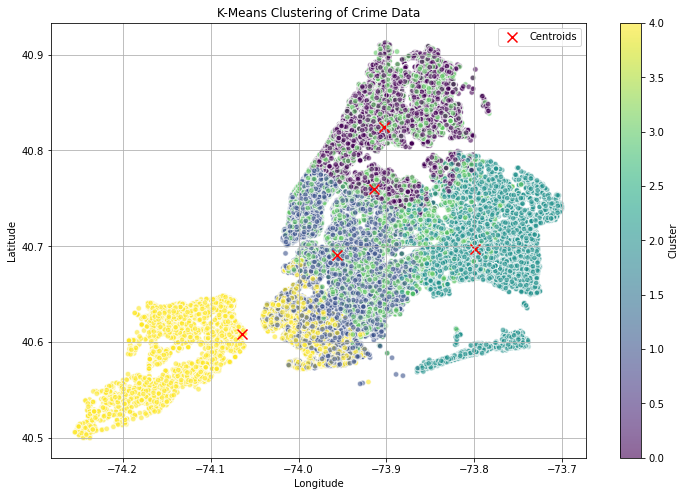

Cluster Centers:
    Latitude  Longitude                       OFNS_DESC
0  40.824387 -73.902729               DANGEROUS WEAPONS
1  40.691388 -73.955701               DANGEROUS WEAPONS
2  40.697267 -73.799850  GRAND LARCENY OF MOTOR VEHICLE
3  40.760024 -73.914412                            RAPE
4  40.608728 -74.064543  INTOXICATED & IMPAIRED DRIVING


In [4]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

data = df_sampled

# Check for missing values
print("Missing values in dataset:")
print(data.isnull().sum())

# Drop rows with missing values or fill them
data = data.dropna(subset=['Latitude', 'Longitude', 'OFNS_DESC'])

# Encode the 'OFNS_DESC' column to numeric values
label_encoder = LabelEncoder()
data['OFNS_DESC_encoded'] = label_encoder.fit_transform(data['OFNS_DESC'])

X = data[['Latitude', 'Longitude', 'OFNS_DESC_encoded']]

# Check for infinite values
if np.isinf(X).any().any():
    raise ValueError("Input contains infinity values")

# Step 2: Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Step 3: Apply K-Means clustering
num_clusters = 5  # You can adjust this based on your needs
kmeans = KMeans(n_clusters=num_clusters, random_state=0)

# Fit KMeans and predict clusters
try:
    data['Cluster'] = kmeans.fit_predict(X_scaled)
except ValueError as e:
    print(f"Error during KMeans fitting: {e}")
    exit()

# Get cluster centers
centers = kmeans.cluster_centers_

# Inverse transform to get original scale
centers_original_scale = scaler.inverse_transform(centers)

# Add cluster centers to the DataFrame
centers_df = pd.DataFrame(centers_original_scale, columns=['Latitude', 'Longitude', 'OFNS_DESC_encoded'])

# Map encoded offense description back to original
centers_df['OFNS_DESC'] = label_encoder.inverse_transform(centers_df['OFNS_DESC_encoded'].astype(int))

# Step 4: Plotting the clusters and centroids
plt.figure(figsize=(12, 8))

scatter = plt.scatter(data['Longitude'], data['Latitude'], c=data['Cluster'], cmap='viridis', alpha=0.6, edgecolors='w', s=30)
plt.colorbar(scatter, label='Cluster')

# Plot centroids
plt.scatter(centers_original_scale[:, 1], centers_original_scale[:, 0], c='red', marker='x', s=100, label='Centroids')

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('K-Means Clustering of Crime Data')
plt.legend()
plt.grid(True)
plt.show()

# Display centroids
print("Cluster Centers:")
print(centers_df[['Latitude', 'Longitude', 'OFNS_DESC']])


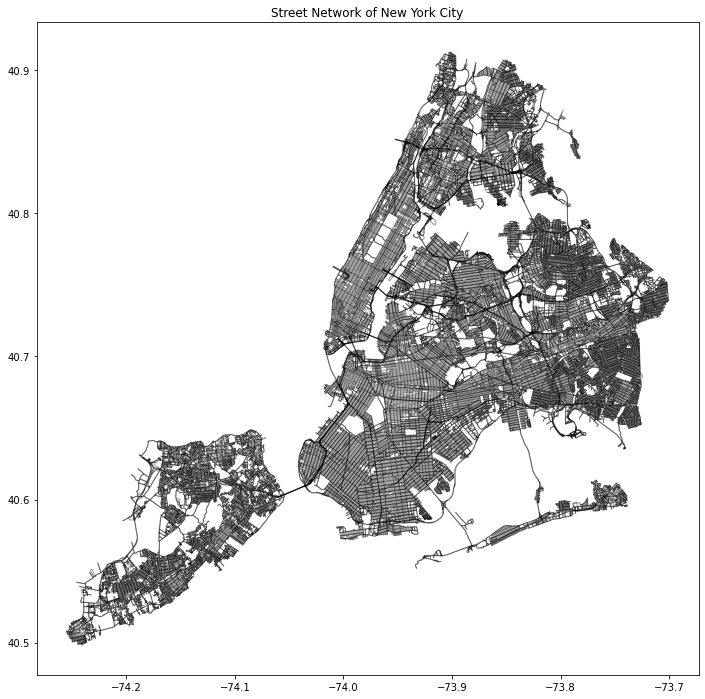

In [6]:
import osmnx as ox
import geopandas as gpd

import matplotlib.pyplot as plt

# Download the street network of New York City
G = ox.graph_from_place('New York City, New York, USA', network_type='drive')

# Convert the graph to a GeoDataFrame
gdf_nodes, gdf_edges = ox.graph_to_gdfs(G)

# Plot the street network
fig, ax = plt.subplots(figsize=(12, 12))
gdf_edges.plot(ax=ax, linewidth=1, edgecolor='black', alpha=0.4)
plt.title('Street Network of New York City')
plt.show()

No path found between 11785237814 and 42878139


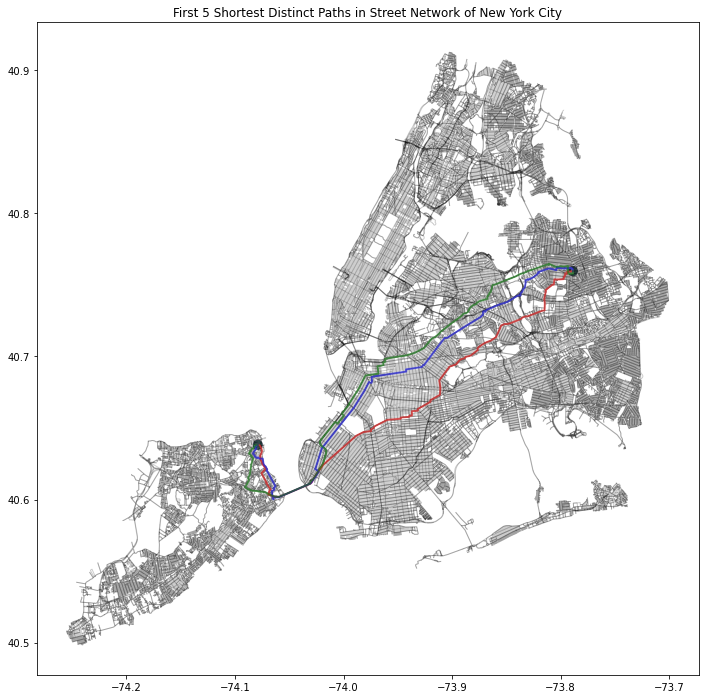

In [9]:
import networkx as nx
import random
import matplotlib.pyplot as plt
import osmnx as ox

# Randomly choose two nodes from the graph
nodes = list(G.nodes)
start_node = random.choice(nodes)
end_node = random.choice(nodes)

def find_shortest_paths(G, source, target, num_paths=5):
    paths = []
    G_temp = G.copy()
    for _ in range(num_paths):
        try:
            path = nx.shortest_path(G_temp, source=source, target=target, weight='length')
            paths.append(path)
            
            # Remove edges in the current path to find a different path next time
            for i in range(len(path) - 1):
                if G_temp.has_edge(path[i], path[i + 1]):
                    G_temp.remove_edge(path[i], path[i + 1])
        
        except nx.NetworkXNoPath:
            print(f"No path found between {source} and {target}")
            break
    
    return paths

# Get 5 distinct shortest paths
paths = find_shortest_paths(G, start_node, end_node, num_paths=5)

# Extract the subgraph containing the nodes in the paths
nodes_in_paths = set()
for path in paths:
    nodes_in_paths.update(path)
subgraph = G.subgraph(nodes_in_paths)

# Convert the subgraph to a GeoDataFrame
gdf_nodes_sub, gdf_edges_sub = ox.graph_to_gdfs(subgraph)

# Plot the entire street network
fig, ax = plt.subplots(figsize=(12, 12))
gdf_edges.plot(ax=ax, linewidth=1, edgecolor='black', alpha=0.2)

# Plot the subgraph with the paths highlighted
gdf_edges_sub.plot(ax=ax, linewidth=1, edgecolor='gray')

# Plot each path with a different color
colors = ['red', 'blue', 'green', 'purple', 'orange']
for i, path in enumerate(paths):
    if i >= len(colors):
        break
    ox.plot_graph_route(subgraph, path, route_linewidth=2, route_color=colors[i], ax=ax, show=False, close=False)

plt.title('First 5 Shortest Distinct Paths in Street Network of New York City')
plt.show()


In [17]:
from scipy.spatial.distance import cdist
import seaborn as sns


# Function to calculate the risk score for a given path based on centroid distances
def calculate_path_risk_score(path, centroids):
    latitudes = [gdf_nodes_sub.loc[node]['y'] for node in path]
    longitudes = [gdf_nodes_sub.loc[node]['x'] for node in path]
    path_points = np.vstack([latitudes, longitudes]).T
    distances = cdist(path_points, centroids[:, :2], 'euclidean')
    sum_distances = np.sum(distances, axis=0)
    risk_score = (1/np.sum(min_distances))*100000
    return risk_score

# Calculate the risk score for each path
path_risk_scores = {i: calculate_path_risk_score(path, centers) for i, path in enumerate(paths)}

# Print the risk scores for each path
for path_index, score in path_risk_scores.items():
    print(f"Path {path_index}: Risk Score = {score}")

# # Plot the KMeans clustering results with centroids
# plt.figure(figsize=(10, 6))
# sns.scatterplot(x='Longitude', y='Latitude', hue='cluster', data=df_sampled, palette='Set1')
# plt.scatter(centroids[:, 1], centroids[:, 0], c='red', marker='x', s=100, label='Centroids')
# plt.xlabel('Longitude')
# plt.ylabel('Latitude')
# plt.title('Crime Clusters Based on Location and Crime Type')
# plt.legend()
# plt.show()

Path 0: Risk Score = 0.6730988046413299
Path 1: Risk Score = 0.6634998302762503
Path 2: Risk Score = 0.6905906654800532
